In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform
import cv2

In [2]:
## -------------------------------------------
def generate_letter_image(letter, font_path, imgsize=100):
    """
    Generate a 100x100 grayscale image of a given letter
    of a given font
    """
    
    ## Test that there is a single character provided
    assert len(letter) == 1, 'The letter provided should contain exactly one alphanumeric character'
    
    ## Test that the character is alphanumeric
    assert letter.isalnum(), 'The letter provided should be alphanumeric'
    
    ## Make sure the entire character is contained in the raw image
    delta_x      = 0
    delta_y      = 0
    font_size    = imgsize*5
    
    left_check   = True
    right_check  = True
    top_check    = True
    bottom_check = True
    
    raw_w = raw_h = imgsize*5
    
    while True:
        
        ## Generate the image using PIL
        image_raw = Image.new(
            "L",                     ## single 8-bit channel
            (raw_w, raw_h),              ## 500x500 px
            0                        ## black background
        )
    
        ## Retrieve font
        font = ImageFont.truetype(font_path, font_size)
    
        ## Handle to draw on image
        draw = ImageDraw.Draw(image_raw)
        width, height = draw.textsize(letter, font=font)
    
        try:
            draw.text((raw_w/2 - width/2 + delta_x, raw_h/2 - height/2 + delta_y), letter, 255, font=font)
        except IOError:
            font_size = int(font_size * 0.9)
            continue
    
        array_raw = np.array(image_raw.getdata()).reshape(raw_w, raw_h)
        
        ## Detect whether or not the character is fully contained,
        ## and determine appropriate action
        
        previous_left_check   = left_check
        previous_right_check  = right_check
        previous_top_check    = top_check
        previous_bottom_check = bottom_check
        
        left_check   = array_raw[:,0].sum()   == 0
        right_check  = array_raw[:,(raw_w-1)].sum() == 0
        top_check    = array_raw[0,:].sum()   == 0
        bottom_check = array_raw[(raw_h-1),:].sum() == 0
        
        all_check = array_raw.sum() > 0
        
        assert all_check, 'Nothing was drawn, make sure the font has a representation for the provided character'
        
        ## When the character is container, the array sum should be superior to 0,
        ## but the bounding box should sum up to 0
        if  left_check and \
            right_check and \
            top_check and \
            bottom_check:
            break
            
        ## Let's find out if the character is too big
        if ((not left_check) and (not right_check)) or ((not top_check) and (not bottom_check)):
            font_size = int(font_size * 0.9)
            continue
            
        ## Shift the character around
        if not left_check:
            if not previous_right_check:
                font_size = int(font_size * 0.9)
            delta_x += width/4
            continue
            
        if not right_check:
            if not previous_left_check:
                font_size = int(font_size * 0.9)
            delta_x -= width/4
            continue
            
        if not top_check:
            if not previous_bottom_check:
                font_size = int(font_size * 0.9)
            delta_y += height/4
            continue
            
        if not bottom_check:
            if not previous_top_check:
                font_size = int(font_size * 0.9)
            delta_y -= height/4
            continue
            
    ## Detect letter edges and crop
    x_projection = array_raw.sum(axis=1)
    x_values = np.nonzero(x_projection)
    x0, x1 = x_values[0][0], x_values[0][-1]
    
    y_projection = array_raw.sum(axis=0)
    y_values = np.nonzero(y_projection)
    y0, y1 = y_values[0][0], y_values[0][-1]
    
    array_crop = array_raw[max(0, x0-3):x1, max(0, y0-3):y1]
    
    scaling_factor = 0.9*imgsize/max(array_crop.shape)
    
    array_crop = transform.rescale(array_crop, scale=scaling_factor, preserve_range=True)
    
    ## Pad the image such that it fits, centered in a 100x100 px image
    array = np.zeros((imgsize,imgsize), dtype='uint8')
    
    x_margin = imgsize - array_crop.shape[1]
    y_margin = imgsize - array_crop.shape[0]
    
    x0 = (x_margin//2 + x_margin%2) - 1
    x1 = (imgsize-1) - x_margin//2
    
    y0 = (y_margin//2 + y_margin%2) - 1
    y1 = (imgsize-1) - y_margin//2
    
    array[y0:y1, x0:x1] = array_crop
    
    return array

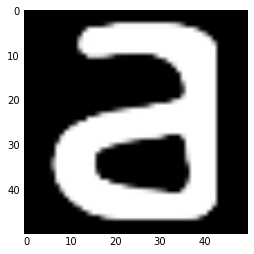

In [3]:
font_dir = os.path.join('/', 'Users', 'mtm', 'Projects', 'FontFinder', 'dafont_fonts')
font_dir2 = os.path.join('/', 'Library', 'Fonts')
font_path = os.path.join(font_dir, 'Vermin Magic.ttf')

img_array = generate_letter_image('a', font_path, imgsize=50)
plt.imshow(img_array, cmap='Greys_r')

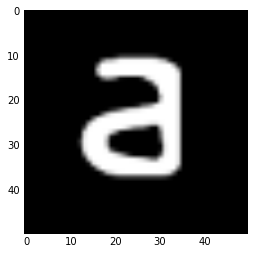

In [12]:
def scale_variations(img, scale_factors=[0.9, 0.8, 0.7, 0.6]):
    """
    Produces scaling variations on image
    """
    
    output_images = []
    
    for sf in scale_factors:
        
        canvas = np.zeros(img.shape, dtype=img.dtype)
        
        new_shape = (int(img.shape[0]*sf), int(img.shape[1]*sf))
        
        img_crop  = cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)
        
        x_margin = img.shape[1] - new_shape[1]
        y_margin = img.shape[0] - new_shape[0]
    
        x0 = (x_margin//2 + x_margin%2) - 1
        x1 = (img.shape[1]-1) - x_margin//2
    
        y0 = (y_margin//2 + y_margin%2) - 1
        y1 = (img.shape[1]-1) - y_margin//2
    
        canvas[y0:y1, x0:x1] = img_crop
        
        output_images.append(canvas)
        
    return output_images
        
imgs = scale_variations(img_array)
plt.imshow(imgs[3], cmap='Greys_r')

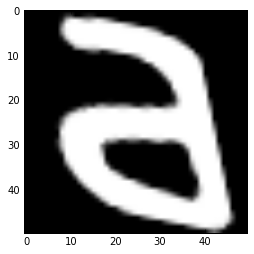

In [46]:
def skew_variations(img, vertical_shear=[0], horizontal_shear=[0]):
    """
    Produces skewing variations on input image
    """
    
    output_images = []
    
    for vs in vertical_shear:
        for hs in horizontal_shear:
            
            origin = np.float32([[0,0],[1,0],[0,1]])
            shear  = np.float32([[hs,vs],[hs,-vs],[-hs,vs]])
            
            x = img.shape[1]//2
            y = img.shape[0]//2
            
            absolufy = np.float32([[x,y],[x,y],[x,y]])
            
            transformed = origin + shear + absolufy

            M = cv2.getAffineTransform(origin+absolufy, transformed)
            output_images.append(cv2.warpAffine(img,M,img.shape))
    
    return output_images

imgs = skew_variations(img_array, vertical_shear=[-0.1, 0.0, 0.1], horizontal_shear=[-0.1, 0.0, 0.1])
plt.imshow(imgs[0], cmap='Greys_r')

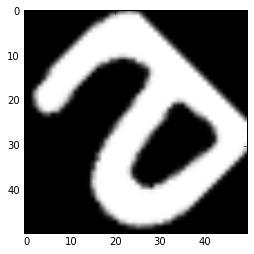

In [56]:
def rotate_variations(img, angles=[]):
    """
    Produces rotation variations on input image
    """
    
    output_images = []
    
    for a in angles:
        
        M = cv2.getRotationMatrix2D((img.shape[0]//2,img.shape[1]//2),a,1)
        output_images.append(cv2.warpAffine(img,M,img.shape))
        
    return output_images

imgs = rotate_variations(img_array, angles=[0,45])
plt.imshow(imgs[1], cmap='Greys_r')

In [58]:
def pixbypix_similarity(img1, img2):
    """
    Determines the pixel by pixel similarity of two images
    """
    
    assert img1.shape == img2.shape, 'Images should be of the same size'
    
    return 1.0 - np.sum(np.absolute(np.subtract(img1, img2)))/(img1.shape[0]*img1.shape[1]*img1.ptp())

print pixbypix_similarity(img_array, imgs[0])

1.0


In [158]:
## Create an array of M images
font_list = [os.path.join(font_dir, font) for font in os.listdir(font_dir)]
font_list += [os.path.join(font_dir2, font) for font in os.listdir(font_dir2)]

In [159]:
print len(font_list)
#font_list = list(np.random.choice(font_list, 10000))
print len(font_list)

45895
45895


In [160]:
font_index = 0
y_fonts = []
for i in range(15):
    x_fonts = []
    for j in range(18):
        try:
            x_fonts.append(generate_letter_image('a', font_list[font_index], imgsize=50))
        except:
            x_fonts.append(np.zeros((50,50), dtype='uint8'))
        font_index += 1
    y_fonts.append(np.hstack(x_fonts))

all_fonts = np.vstack(y_fonts)

cv2.imwrite('as.png', all_fonts)

True

In [161]:
## A function to generate random noise
def generate_noise(imgsize=100):
    return np.random.random(size=(imgsize, imgsize))

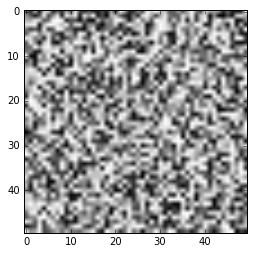

In [162]:
img_array = generate_noise(imgsize=50)
plt.imshow(img_array, cmap='Greys_r')

In [163]:
## ----------------------------------------
def generate_training_sample(char, img, font_list, n_random=10):
    """
    A function to generate the training sample
    """
    
    ## normalize the image
    norm_img = np.multiply(np.add(img, -np.min(img)), 1.0/np.ptp(img))
    
    ## Get image dimensions
    w,h = norm_img.shape
    assert w == h, 'Char image should be square'
    
    ## Obtain random fonts
    random_fonts = np.random.choice(font_list, n_random)
    random = []

    for font in random_fonts:
        try:
            rdn_img      = generate_letter_image(char, font, imgsize=w)
            rdn_norm_img = np.multiply(rdn_img, 1.0/256)
            
            random.append(np.ravel(rdn_norm_img))
        except:
            random.append(np.ones(w*w))
            
    ## Put together the different types of training samples
    n_noise = 10
    noise   = [np.ravel(generate_noise(imgsize=w)) for i in range(n_noise)]
    
    n_zeros = 10
    zeros   = [np.zeros(w*w)]*n_zeros
    
    n_signal = n_random + n_noise + n_zeros
    signal   = [np.ravel(norm_img)]*n_signal
    
    n_total = 2*n_signal
    
    X = np.stack(signal + noise + zeros + random, axis=0)
    y = np.array([0]*n_signal + [1]*n_noise + [2]*n_zeros + range(3, n_random+3))
    
    return X,y
    

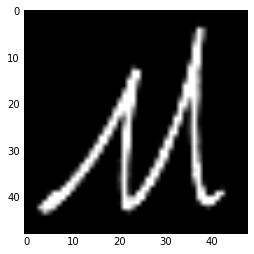

In [164]:
mtest = Image.open('Mtest.png')
mtest_array = np.array(mtest.getdata())
mtest_array = np.sum(mtest_array, axis=1)
mtest_array.shape = (48,48)
mtest_array = np.multiply(mtest_array, 1.0/np.max(mtest_array))
mtest_array = 1.0 - mtest_array
plt.imshow(mtest_array, cmap='Greys_r')

In [165]:
font_path = os.path.join(font_dir, 'Hickory Jack.ttf')
char = 'M'
d    = 48
img = generate_letter_image(char, font_path, imgsize=d)
X_train, y_train = generate_training_sample(char, mtest_array, font_list, n_random=100)

In [166]:
from sktfnn.neuralnetwork import NeuralNetwork
from sktfnn.layer import Layer, ConvLayer, DropoutLayer

In [187]:
nn = NeuralNetwork(
    hidden_layers = [
        ConvLayer(
            img_size=(d,d),
            patch_size=(6,6),
            n_features=32,
            pooling='max',
            pooling_size=(3,3),
        ),
        ConvLayer(
            img_size=(16,16),
            n_features=64,
            pooling='max',
        ),
        Layer(
            n_neurons=512,
            activation='relu'
        )
    ],
    learning_algorithm='GradientDescent',
    cost_function='log-likelihood',
    learning_rate=2e-2,
    early_stopping=False,
    stagnation=10,
    n_epochs=20,
    mini_batch_size=y_train.shape[0]
    )

In [188]:
%time nn.fit(X_train, y_train, verbose=True, val_X=X_train, val_y=y_train)

Epoch 0, validation sample accuracy: 0.00416666688398
Epoch 1, validation sample accuracy: 0.5
Epoch 2, validation sample accuracy: 0.00416666688398
Epoch 3, validation sample accuracy: 0.5
Epoch 4, validation sample accuracy: 0.5
Epoch 5, validation sample accuracy: 0.533333361149
Epoch 6, validation sample accuracy: 0.541666686535
Epoch 7, validation sample accuracy: 0.541666686535
Epoch 8, validation sample accuracy: 0.550000011921
Epoch 9, validation sample accuracy: 0.550000011921
Epoch 10, validation sample accuracy: 0.554166674614
Epoch 11, validation sample accuracy: 0.554166674614
Epoch 12, validation sample accuracy: 0.558333337307
Epoch 13, validation sample accuracy: 0.5625
Epoch 14, validation sample accuracy: 0.608333349228
Epoch 15, validation sample accuracy: 0.608333349228
Epoch 16, validation sample accuracy: 0.608333349228
Epoch 17, validation sample accuracy: 0.608333349228
Epoch 18, validation sample accuracy: 0.608333349228
Epoch 19, validation sample accuracy: 0.

In [169]:
# low_level_features = nn.hidden_layers[0].weights.eval()

In [170]:
# low_level_features.shape

In [171]:
# fig, ax = plt.subplots(32, figsize=(2, 64))

# for i in range(32):
#     ax[i].imshow(low_level_features[:,:,0,i], cmap='Greys_r')

In [181]:
images = []
scores = []
fonts  = []

progress = 0

for font in font_list:
    
    if progress%1000 == 0:
        print progress
    
    try:
        image = generate_letter_image(char, font, imgsize=48)
    except:
        image = np.ones((d,d), dtype='uint8')
        
    norm_image = np.multiply(image, 1.0/256)
    
    images.append(image)
    fonts.append(font)
    
    norm_image.shape = (1,d*d)
    
    scores.append(nn.predict_proba(norm_image)[0][0])
    
    progress += 1
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


In [182]:
sorted_images = sorted(zip(scores, images, fonts), key=lambda x: x[0], reverse=True)

In [183]:
font_index = 0
y_fonts = []
for i in range(100):
    x_fonts = []
    for j in range(100):
        img = sorted_images[i*100 + j][1]
        if font_path == sorted_images[i*100 + j][2]:
            img[:,0] = 255
            img[:,-1] = 255
            img[0,:] = 255
            img[-1,:] = 255
        
        x_fonts.append(img)
    y_fonts.append(np.hstack(x_fonts))

all_fonts = np.vstack(y_fonts)

In [184]:
cv2.imwrite('out.png', all_fonts)

True

In [185]:
for i, tup in enumerate(sorted_images):
    if font_path == tup[2]:
        print i

15280


In [186]:
for i, (score, image, font) in enumerate(sorted_images):
    print score, font
    if i > 100: break

0.851849 /Users/mtm/Projects/FontFinder/dafont_fonts/Pettra.ttf
0.8488 /Users/mtm/Projects/FontFinder/dafont_fonts/EclipseDEMO.ttf
0.702016 /Users/mtm/Projects/FontFinder/dafont_fonts/JaponesaShadow.ttf
0.669765 /Users/mtm/Projects/FontFinder/dafont_fonts/bloodlustout.ttf
0.65921 /Users/mtm/Projects/FontFinder/dafont_fonts/Oh Jay - Dker.ttf
0.651794 /Users/mtm/Projects/FontFinder/dafont_fonts/commersial_script.ttf
0.577024 /Users/mtm/Projects/FontFinder/dafont_fonts/TCLESCUE.TTF
0.501931 /Users/mtm/Projects/FontFinder/dafont_fonts/Sabrinahandfont.ttf
0.498802 /Users/mtm/Projects/FontFinder/dafont_fonts/I am Hueca.otf
0.473339 /Users/mtm/Projects/FontFinder/dafont_fonts/DK Limoen.otf
0.461449 /Users/mtm/Projects/FontFinder/dafont_fonts/I am Hueca.ttf
0.460791 /Users/mtm/Projects/FontFinder/dafont_fonts/CrazyCurlz.ttf
0.453096 /Users/mtm/Projects/FontFinder/dafont_fonts/BEANTOWN.TTF
0.451899 /Users/mtm/Projects/FontFinder/dafont_fonts/alienleagueii3d.ttf
0.451484 /Users/mtm/Projects/Font